# Pysort dataset

Learn to auto-encode python sorting programs. In particular, we consider 51 manually generated programs that implement the [insertion sort](https://en.wikipedia.org/wiki/Insertion_sort) algorithm.

### Set up hyper-parameters of the experiment

Note: In its default format, this experiment takes quite long. If you want to speed it up, consider reducing the $T$ parameter, i.e. the number of training epochs. Further, you may want to reduce $M$, i.e. th enumber of repeats in the experiment.

In [1]:
import pysort_data
import torch
import edist.tree_utils as tu
import tree_grammar

task = 'pysort'
data_folder = 'pysort'
data_folder_hyper = 'pysort_hyper'

# the number of experimental repeats
M = 10
# the number of training epochs
# set such that T * N = 10000
T = 313
# the number of trees in each epoch (minibatch size)
N = 32
# the number of training epochs for hyper-parameter optimization
# set such that T_hyper * N = 10000
T_hyper = 313
# the number of test trees for hyper-parameter optimization
N_test_hyper = 10
# the number of trials for hyper-parameter optimization
M_hyper = 20

# the learning rate
learning_rate = 1E-3
# learning rate adjustment settings
min_lr = 1E-4
factor = 0.5
patience = 3
# the L2 regularization strength
weight_decay = 0.

# the number of iterations between prints
print_step = 10
print_step_hyper = 10
# the update factor for the moving average
avg_factor = 0.05

# load the data, compute the dataset size, and the maximum grammar rule sequence length
# in the data
trees, filenames = tu.dataset_from_json(data_folder)
dataset_size = len(trees)

trees_hyper, filenames_hyper = tu.dataset_from_json(data_folder_hyper)
dataset_size_hyper = len(trees_hyper)

parser = tree_grammar.TreeParser(pysort_data.grammar)
max_size = 0

for nodes, adj in (trees + trees_hyper):
    # parse the tree via the tree grammar
    seq = parser.parse(nodes, adj)
    if len(seq) > max_size:
        max_size = len(seq)
print('Read %d trees; maximum size: %d' % (dataset_size + dataset_size_hyper, max_size))

Read 345 trees; maximum size: 168


###  Specify models and model hyperparameters

In [2]:
# set up model setup functions
import dvae
import grammar_vae as gvae
import tree_echo_state_auto_encoder as tesae
import gru_tree_grammar_auto_encoder as gru_tg_ae
import recursive_tree_grammar_auto_encoder as rtg_ae

model_names = ['dvae', 'gvae', 'tes-ae', 'gru-tg-ae', 'rtg-ae', 'rtg-ae_hid']

# the number of neurons for all models
dim = 256
# the encoding dimensionality for the variational auto-encoder
dim_vae  = 16
# the VAE regularization strengths to try; this will be optimized later
betas_hyper = [1E-5, 1E-3, 0.01, 0.1, 1.]
sigma_scalings_hyper = [1E-5, 1E-3, 0.01, 0.1, 1.]
# The hyperparameters for TES-AE to try; this will be optimized later
sparsities_hyper = [0.05, 0.1, 0.2, 0.4, 0.8]
radii_hyper      = [0.5, 0.7, 0.8, 0.9, 0.95]
reguls_hyper     = [1E-7, 1E-5, 1E-3, 0.1]
# the hidden dimensionality for tgvae
dim_hid = 32

# the convolutional parameters for the GVAE model, taken from the reference implementation at
# https://github.com/mkusner/grammarVAE/blob/master/models/model_zinc.py
conv_params = [(9, 9), (10, 10), (10, 11)]
# the number of decoding layers for the GVAE model; again, taken from:
# https://github.com/mkusner/grammarVAE/blob/master/models/model_zinc.py
gvae_layers = 3

types_idxs = {}
types = []
i = 0
for sym in pysort_data._alphabet:
    types.append(sym)
    types_idxs[sym] = i
    i += 1
graphs = []
for nodes, adj in trees:
    g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
    graphs.append(g)
def setup_dvae():
    return dvae.DVAE(max_n = max_size + 2, nvt = len(types_idxs) + 2, hs = dim, nz = dim_vae)
def setup_gvae():
    return gvae.GrammarVAE(pysort_data.grammar, dim = dim, max_len = max_size, dim_vae = dim_vae, conv_params = conv_params, gru_dim = dim, num_gru_layers = gvae_layers)
def setup_gru_tg_ae():
    return gru_tg_ae.RecurrentTreeAutoEncoder(pysort_data.grammar, dim = dim, dim_vae = dim_vae)
def setup_rtg_ae():
    return rtg_ae.TreeGrammarAutoEncoder(pysort_data.grammar, dim = dim, dim_vae = dim_vae)
def setup_rtg_ae_hid():
    return rtg_ae.TreeGrammarAutoEncoder(pysort_data.grammar, dim = dim, dim_hid = dim_hid, dim_vae = dim_vae)

setup_functions = [setup_dvae, setup_gvae, None, setup_gru_tg_ae, setup_rtg_ae, setup_rtg_ae_hid]

if len(setup_functions) != len(model_names):
    raise ValueError('expected one setup function per model')

# print the number of parameters for each model
for model_idx in range(len(model_names)):
    num_params = 0
    if model_names[model_idx] == 'tes-ae':
        for nont in pysort_data.grammar._nonts:
            num_params += dim * len(pysort_data.grammar._rules[nont])
    else:
        model = setup_functions[model_idx]()
        for key in model.state_dict():
            num_params += model.state_dict()[key].numel()
    print('%s: %d parameters' % (model_names[model_idx], num_params))

dvae: 1859417 parameters
gvae: 1630263 parameters
tes-ae: 13824 parameters
gru-tg-ae: 445280 parameters
rtg-ae: 5493600 parameters
rtg-ae_hid: 1662240 parameters


### Hyperparameter optimization (of beta and sigma_scaling)

In [3]:
import random
import os
import numpy as np
import edist.ted as ted
import edist.tree_utils as tu

# try to load samples
if os.path.exists('results/%s_schedule_hyper.csv' % task):
    schedule_hyper = np.loadtxt('results/%s_schedule_hyper.csv' % task, dtype=int, delimiter='\t', skiprows = 1)
    print('loaded sample indices from results/%s_schedule_hyper.csv' % task)
else:
    # subsample the training data
    N_train_hyper = dataset_size_hyper - N_test_hyper
    train_idxs_hyper = np.random.choice(dataset_size_hyper, N_train_hyper, replace = False)
    # create a training schedule, i.e. N * T_hyper indices of the training data
    k = N_train_hyper
    schedule_hyper = np.zeros(N*T_hyper, dtype=int)
    while k < N * T_hyper:
        schedule_hyper[(k-N_train_hyper):k] = np.random.permutation(train_idxs_hyper)
        k += N_train_hyper
    schedule_hyper[(k-N_train_hyper):] = np.random.permutation(train_idxs_hyper)[:(N*T_hyper-k+N_train_hyper)]
    np.savetxt('results/%s_schedule_hyper.csv' % task, schedule_hyper, header='index', fmt='%d', comments = '')

test_data = []
test_idxs_hyper = np.setdiff1d(np.arange(dataset_size_hyper), schedule_hyper)
for j in test_idxs_hyper:
    test_data.append(trees_hyper[j])

# try to load hyper-parameter optimization results
if os.path.exists('results/%s_rmses_hyper.csv' % task):
    errors_hyper = np.loadtxt('results/%s_rmses_hyper.csv' % task, delimiter='\t', skiprows = 1).T
    print('loaded hyperparameter optimization RMSES from results/%s_rmses_hyper.csv' % task)
else:
    errors_hyper = np.empty((len(model_names)+2, M_hyper))
    errors_hyper[:, :] = np.nan

if os.path.exists('results/%s_losses_hyper.csv' % task):
    losses_hyper = np.loadtxt('results/%s_losses_hyper.csv' % task, delimiter='\t', skiprows = 1).T
    print('loaded hyperparameter optimization losses from results/%s_losses_hyper.csv' % task)
else:
    losses_hyper = np.empty((len(model_names)+2, M_hyper))
    losses_hyper[:, :] = np.nan

# check how many runs are completed
runs_completed = np.sum(np.all(np.isfinite(errors_hyper), 0))

# start the hyper-parameter optimization
for run in range(runs_completed, M_hyper):
    print('--- optimization run %d of %d ---' % (run+1, M_hyper))

    # sample a random beta and sigma_scaling
    # but definitely take beta = 1 and sigma_scaling = 1 in the first run to make sure we have
    # this as a baseline
    if run == 0:
        beta = 1.
        sigma_scaling = 1.
    else:
        beta = betas_hyper[random.randrange(len(betas_hyper))]
        sigma_scaling = sigma_scalings_hyper[random.randrange(len(sigma_scalings_hyper))]
    errors_hyper[0, run] = beta
    errors_hyper[1, run] = sigma_scaling
    losses_hyper[0, run] = beta
    losses_hyper[1, run] = sigma_scaling

    print('beta = %g, sigma_scaling = %g' % (beta, sigma_scaling))

    for model_idx in range(len(model_names)):
        # ignore dvaes because the hyper-parameters are fixed by the built-in training function
        if model_names[model_idx] == 'dvae' or model_names[model_idx] == 'tes-ae':
            errors_hyper[model_idx+2, run] = 0.
            losses_hyper[model_idx+2, run] = 0.
            continue

        print('--- model %s ---' % model_names[model_idx])
        # set up the model
        model = setup_functions[model_idx]()

        # set up the optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, verbose=True, min_lr=min_lr)
        # start training
        avg_loss = None
        for epoch in range(1, T_hyper + 1):
            optimizer.zero_grad()
            # handle a minibatch of trees
            minibatch_loss = torch.zeros(1)
            for j in range(N*(epoch-1), N*epoch):
                nodes, adj = trees_hyper[schedule_hyper[j]]
                # compute auto-encoding loss
                loss = model.compute_loss(nodes, adj, beta = beta, sigma_scaling = sigma_scaling)
                minibatch_loss = minibatch_loss + loss
            # compute gradient
            minibatch_loss.backward()
            # perform an optimizer step
            optimizer.step()
            # apply the learning rate scheduler
            scheduler.step(minibatch_loss)
            # update the moving loss average
            minibatch_loss = minibatch_loss.item() / N
            if avg_loss is None:
                avg_loss = minibatch_loss
            else:
                avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
            if epoch % print_step_hyper == 0:
                print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode it
            _, z = model.encode(nodes, adj)
            # decode it again
            if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
                nodes_act, adj_act, _ = model.decode(z)
            else:
                nodes_act, adj_act, _ = model.decode(z, max_size = max_size)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test_hyper)
        print('obtained RMSE of %g' % rmse)
        errors_hyper[model_idx+2, run] = rmse
        losses_hyper[model_idx+2, run] = avg_loss
    # store the hyperparameter optimization data
    np.savetxt('results/%s_rmses_hyper.csv' % task, errors_hyper.T, delimiter='\t', header='\t'.join(['beta', 'sigma_scaling'] + model_names), fmt='%g', comments = '')
    np.savetxt('results/%s_losses_hyper.csv' % task, losses_hyper.T, delimiter='\t', header='\t'.join(['beta', 'sigma_scaling'] + model_names), fmt='%g', comments = '')
# select the optimal hyper-parameter for each model
betas = np.zeros(len(model_names))
sigma_scalings = np.zeros(len(model_names))
for model_idx in range(len(model_names)):
    # ignore dvaes because the hyper-parameters are fixed by the built-in training function
    if model_names[model_idx] == 'dvae' or model_names[model_idx] == 'tes-ae':
        continue
    opt_run = np.argmin(errors_hyper[model_idx+2, :])
    betas[model_idx] = errors_hyper[0, opt_run]
    sigma_scalings[model_idx] = errors_hyper[1, opt_run]
    print('optimal parameters for model %s: beta = %g, sigma_scaling = %g (error = %g)' % (model_names[model_idx], betas[model_idx], sigma_scalings[model_idx], errors_hyper[model_idx+2, opt_run]))

loaded sample indices from results/pysort_schedule_hyper.csv
loaded hyperparameter optimization RMSES from results/pysort_rmses_hyper.csv
loaded hyperparameter optimization losses from results/pysort_losses_hyper.csv
optimal parameters for model gvae: beta = 1, sigma_scaling = 1 (error = 68.7059)
optimal parameters for model gru-tg-ae: beta = 1, sigma_scaling = 0.1 (error = 46.2017)
optimal parameters for model rtg-ae: beta = 0.01, sigma_scaling = 1e-05 (error = 32.5284)
optimal parameters for model rtg-ae_hid: beta = 0.1, sigma_scaling = 0.1 (error = 39.0858)


### Hyperparameter optimization (of sparsity and radius for TES-AE)

In [4]:
import random
import os
import numpy as np
import edist.ted as ted


# try to load hyper-parameter optimization results
if os.path.exists('results/%s_rmses_tes_ae_hyper.csv' % task):
    errors_tesae_hyper = np.loadtxt('results/%s_rmses_tes_ae_hyper.csv' % task, delimiter='\t', skiprows = 1).T
else:
    # sample trees in advance
    train_idxs_hyper = np.unique(schedule_hyper)
    training_data = []
    for j in train_idxs_hyper:
        training_data.append(trees_hyper[j])

    print('Sampled %d training trees' % len(training_data))

    test_idxs_hyper = np.setdiff1d(np.arange(dataset_size_hyper), schedule_hyper)
    test_data = []
    for j in test_idxs_hyper:
        test_data.append(trees_hyper[j])

    print('Sampled %d test trees' % len(test_data))
    
    errors_tesae_hyper = np.zeros((4, M_hyper))
    # start the hyper-parameter optimization
    for run in range(M_hyper):
        print('--- optimization run %d of %d ---' % (run+1, M_hyper))

        # sample a random sparsity and radius
        sparsity = sparsities_hyper[random.randrange(len(sparsities_hyper))]
        radius   = radii_hyper[random.randrange(len(radii_hyper))]
        regul    = reguls_hyper[random.randrange(len(reguls_hyper))]
        errors_tesae_hyper[0, run] = sparsity
        errors_tesae_hyper[1, run] = radius
        errors_tesae_hyper[2, run] = regul

        print('sparsity = %g, radius = %g, regul = %g' % (sparsity, radius, regul))

        # setup model
        model = tesae.TESAutoEncoder(pysort_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
        # train the model
        model.fit_svm(training_data)
        print('completed TES-AE training')
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode it
            _, z = model.encode(nodes, adj)
            # decode it again
            nodes_act, adj_act, _ = model.decode(z, max_size = 100)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test_hyper)
        print('obtained RMSE of %g' % rmse)
        errors_tesae_hyper[-1, run] = rmse
    # store the hyperparameter optimization data
    np.savetxt('results/%s_rmses_tes_ae_hyper.csv' % task, errors_tesae_hyper.T, delimiter='\t', header='\t'.join(['sparsity', 'radius', 'tes-ae']), fmt='%g', comments = '')
# select the optimal hyper-parameters for TES-AE
opt_run  = np.argmin(errors_tesae_hyper[-1, :])
sparsity = errors_tesae_hyper[0, opt_run]
radius   = errors_tesae_hyper[1, opt_run]
regul    = errors_tesae_hyper[2, opt_run]
print('optimal parameters for model tes-ae: sparsity = %g, radius = %g, regul = %g (error = %g)' % (sparsity, radius, regul, errors_tesae_hyper[-1, opt_run]))
# update the setup function
def setup_tes_ae():
    return tesae.TESAutoEncoder(pysort_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
setup_functions[model_names.index('tes-ae')] = setup_tes_ae

optimal parameters for model tes-ae: sparsity = 0.4, radius = 0.7, regul = 1e-07 (error = 19.0945)


### Perform the actual experiment

In [5]:
import time
import joblib
import numpy as np
import edist.ted as ted
from sklearn.model_selection import KFold
import os

# try to load crossvalidation folds
if os.path.exists('results/%s_train_idxs.csv' % task):
    train_idxs = np.loadtxt('results/%s_train_idxs.csv' % task, delimiter='\t', skiprows = 1, dtype=int).T
    test_idxs = np.loadtxt('results/%s_test_idxs.csv' % task, delimiter='\t', skiprows = 1, dtype=int).T
    print('loaded training indices from results/%s_train_idxs.csv and test indices from results/%s_test_idxs.csv' % (task, task))
else:
    # perform an M-fold crossvalidation split and store it
    kf = KFold(M, shuffle=True)
    train_idxs = -np.ones((M, dataset_size), dtype=int)
    test_idxs  = -np.ones((M, int(dataset_size/M)+1), dtype=int)
    run = 0
    for train_index2, test_index2 in kf.split(trees):
        # subsample from the training and test data
        train_idxs[run, :len(train_index2)] = train_index2
        test_idxs[run,  :len(test_index2)]  = test_index2
        run += 1
    np.savetxt('results/%s_train_idxs.csv' % task, train_idxs.T, delimiter='\t', header='\t'.join([str(i) for i in range(M)]), fmt='%d', comments = '')
    np.savetxt('results/%s_test_idxs.csv'  % task, test_idxs.T,  delimiter='\t', header='\t'.join([str(i) for i in range(M)]), fmt='%d', comments = '')
    
# try to load results
if os.path.exists('results/%s_runtimes.tmp' % task):
    errors   = np.loadtxt('results/%s_rmses.tmp' % task, delimiter='\t', skiprows = 1).T
    runtimes = np.loadtxt('results/%s_runtimes.tmp' % task, delimiter='\t', skiprows = 1).T
    learning_curves = np.loadtxt('results/%s_learning_curves.tmp' % task, delimiter='\t', skiprows = 1).T
    print('loaded partial results from results/%s_*.tmp' % task)
else:
    errors = np.empty((len(model_names), M))
    errors[:, :] = np.nan
    runtimes = np.zeros((len(model_names), M))
    learning_curves = np.zeros((len(model_names), T))
# find how many runs have already_completed
runs_completed = np.sum(np.all(runtimes > 1E-3, 0))

# start the remaining runs
for run in range(runs_completed, M):
    print('--- crossvalidation fold %d of %d ---' % (run+1, M))

    # create a training data schedule
    train_idxs_r = train_idxs[run, train_idxs[run, :] >= 0]
    N_train = len(train_idxs_r)
    k = N_train
    schedule = np.zeros(N*T, dtype=int)
    while k < N * T:
        schedule[(k-N_train):k] = np.random.permutation(train_idxs_r)
        k += N_train
    schedule[(k-N_train):] = np.random.permutation(train_idxs_r)[:(N*T-k+N_train)]

    # get graphs in the training data
    gs = []
    for i in schedule:
        gs.append(graphs[i])

    # retrieve test data
    test_data = []
    for i in test_idxs[run, test_idxs[run, :] >= 0]:
        test_data.append(trees[i])

    # check which models have already been computed
    models_left = np.argwhere(runtimes[:, run] < 1E-3)[:, 0]

    for model_idx in models_left:
        print('--- model %s ---' % model_names[model_idx])
        # set up the model
        model = setup_functions[model_idx]()

        start_time = time.time()
        if model_names[model_idx] != 'dvae' and model_names[model_idx] != 'tes-ae':
            # set up the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=factor, patience=patience, verbose=True, min_lr=min_lr)
            # start training
            avg_loss = None
            for epoch in range(1, T + 1):
                optimizer.zero_grad()
                # handle a minibatch of trees
                minibatch_loss = torch.zeros(1)
                for j in range(N*(epoch-1), N*epoch):
                    nodes, adj = trees[schedule[j]]
                    # compute auto-encoding loss
                    loss = model.compute_loss(nodes, adj, beta = betas[model_idx], sigma_scaling = sigma_scalings[model_idx])
                    minibatch_loss = minibatch_loss + loss
                # compute gradient
                minibatch_loss.backward()
                # perform an optimizer step
                optimizer.step()
                # apply the learning rate scheduler
                scheduler.step(minibatch_loss)
                # update the moving loss average
                minibatch_loss = minibatch_loss.item() / N
                learning_curves[model_idx, epoch-1] += minibatch_loss
                if avg_loss is None:
                    avg_loss = minibatch_loss
                else:
                    avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
                if(epoch % print_step == 0):
                    print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
        elif model_names[model_idx] == 'dvae':
            # use the special D-VAE training function with one epoch
            learning_curve_dvae = dvae.train_dvae(model, gs, lr = learning_rate, epochs = 1, batch_size = 16)
            # store the learning curve
            # do a length normalization step
            # TODO This is only necessary because we have half the batch size for DVAE for RAM reasons
            lcd = np.array(learning_curve_dvae)
            lcd = 0.5 * (lcd[:-1:2] + lcd[1::2])
            learning_curves[model_idx, :] += lcd
        elif model_names[model_idx] == 'tes-ae':
            # use the special TES-AE training function
            training_data = []
            for i in train_idxs_r:
                training_data.append(trees[i])
            model.fit_svm(training_data)
        else:
            raise ValueError('internal error; unknown model name')
        runtimes[model_idx, run] = time.time() - start_time
        print('finished training after %g seconds' % runtimes[model_idx, run])
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode the current test tree
            if len(model_names[model_idx]) < 4 or model_names[model_idx][:4] != 'dvae':
                _, z = model.encode(nodes, adj)
            else:
                g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
                z, _ = model.encode([g])
            # decode it again
            if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
                nodes_act, adj_act, _ = model.decode(z)
            elif len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'dvae':
                g_decoded   = model.decode(z)[0]
                nodes_act, adj_act = dvae.igraph_to_tree(g_decoded, types, True)
            else:
                nodes_act, adj_act, _ = model.decode(z, max_size = max_size)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / len(test_data))
        print('obtained RMSE of %g' % rmse)
        errors[model_idx, run] = rmse

        # store the data in order to continue where we left off later
        np.savetxt('results/%s_rmses.tmp' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
        np.savetxt('results/%s_runtimes.tmp' % task, runtimes.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
        np.savetxt('results/%s_learning_curves.tmp' % task, learning_curves.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

        # store the best model yet
        if run == 0 or rmse < np.min(errors[model_idx, :run]):
            if model_names[model_idx] != 'tes-ae':
                torch.save(model.state_dict(), 'results/%s_%s.torch' % (task, model_names[model_idx]))
            else:
                joblib.dump(model, 'results/%s_%s.joblib' % (task, model_names[model_idx]))


loaded training indices from results/pysort_train_idxs.csv and test indices from results/pysort_test_idxs.csv
loaded partial results from results/pysort_*.tmp


### Visualize learning curves

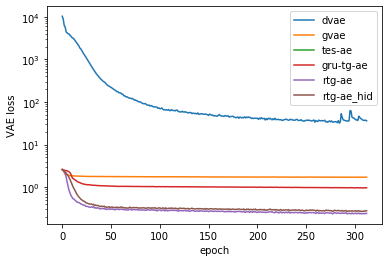

In [6]:
import matplotlib.pyplot as plt
plt.semilogy(learning_curves.T / M)
plt.legend(model_names)
plt.xlabel('epoch')
plt.ylabel('VAE loss')
plt.show()

### Store results

In [7]:
np.savetxt('results/%s_rmses.csv' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
np.savetxt('results/%s_runtimes.csv' % task, runtimes.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
np.savetxt('results/%s_learning_curves.csv' % task, learning_curves.T / M, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')